# Initial Analysis

In this document, we aim to collate all the cleaned data to get an overview of our datasets. We'll be exploring statistics for the datasets in order to get an understanding of how they are structured, the distribution of the data and the contrast/similarities between the games and movie datasets

In [196]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns
from pathlib import Path

In [197]:
#The minimum accepted number for a franchise:
minimum_franchise_count = 3

In [198]:
#Specifications for the graphs
plot_title_size = 30
subplot_title_size = 25
axis_label_size = 22
tick_label_size = 15

In [199]:
# We get a lot of columns, this causes it to show all of them:
pd.set_option("display.max_columns", None)

In [200]:
movies_df = pd.read_csv("clean_data\clean_movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_data\clean_games_with_franchises.csv", index_col = 0)

D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [201]:
movies_df.sample()

,franchise_id,franchise_name,movie_name,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
NaN,NaN,NaN,NaN,tt1024965,Never Apologize,0.0,2007.0,111,Documentary,7.3,264.0


In [202]:
games_df.sample()

,franchise_name,franchise_id,tconst,titleType,primaryTitle,startYear,isAdult,averageRating,numVotes,game_id,best_fit_ratio,genres,developers,platforms,publishers,rating
5367,NaN,NaN,tt0961184,videoGame,Echo: Secrets of the Lost Cavern,2005,0,7.4,11.0,NaN,85.5,"['History', 'Adventure']",NaN,NaN,NaN,NaN


We'll create a naming convention, renaming columns to standardise the column names. We'll also drop any unnecessary columns

In [203]:
games_df = games_df.rename(columns = {"titleType": "type", "rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
games_df = games_df.drop(["game_id", "best_fit_ratio"], axis = 1)
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

We clean up the genres column in games

In [204]:
games_df.genres = games_df.genres.apply(lambda x: x.strip("[]").split(","))
games_df.genres = games_df.genres.apply(lambda x: [i.strip(" '") for i in x])
games_df.genres = games_df.genres.apply(lambda x: ', '.join(x))

Rename the type of release so it's easy to make a distinction.

In [205]:
movies_df["type"] = "movie"
games_df["type"] = "game"

Combine the dataframes into a single dataframe

In [206]:
complete_df = pd.concat([movies_df, games_df])
complete_df = complete_df.reset_index(drop = True)

## Working with the combined dataset

Remove non-numerical years from data and convert to int

In [207]:
def convert_years(year):
    if type(year) == str:
        if year == "\\N":
            return 0
        else:
            return int(year)
    else:
        return int(year)

In [208]:
complete_df["year"] = complete_df["year"].apply(lambda x : convert_years(x))
complete_df = complete_df.loc[(complete_df['year'] > 1800) & (complete_df['year'] < 2024)]

We'll create a number_of_releases column which contains the number of releases in each franchise.

In [209]:
complete_df['number_of_releases'] = complete_df['franchise_id'].map(complete_df['franchise_id'].value_counts())

Get total number of franchises:

In [210]:
print("Total movie franchises: ", complete_df[complete_df["type"] == "movie"].franchise_id.nunique())
print("Total game franchises: ", complete_df[complete_df["type"] == "game"].franchise_id.nunique())

Total movie franchises:  1142
Total game franchises:  2081


We want to remove any movie or game franchises where the total franchise count is below the minimum permitted. This could have happened due to rapidfuzz being unable to match all the entries. We want to ensure we can still get as accurate a picture of how franchises work.

In [211]:
complete_df[["franchise_id", "franchise_name", "number_of_releases"]] = complete_df[["franchise_id", "franchise_name", "number_of_releases"]].apply(lambda x: np.nan if x["number_of_releases"] < minimum_franchise_count else x, axis=1)

We can see how this has affected the total number of franchises:

In [212]:
print("Total movie franchises: ", complete_df[complete_df["type"] == "movie"].franchise_id.nunique())
print("Total game franchises: ", complete_df[complete_df["type"] == "game"].franchise_id.nunique())

Total movie franchises:  845
Total game franchises:  1166


Normalise the genres format turning them all into lists:

In [213]:
def string_to_list(x):
    if x == '\\N':
        return []
    else:
        return x.split(',')

In [214]:
complete_df["genres"] = complete_df["genres"].apply(lambda x: string_to_list(x))

In [215]:
complete_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases
0,The Aldrich Family,f0,tt0032123,What a Life,1939,0.0,75,"[Comedy, Drama]",6.9,93.0,movie,NaN,NaN,NaN,NaN,11.0
1,The Aldrich Family,f0,tt0033834,Life with Henry,1940,0.0,80,"[Comedy, Family, Music]",6.0,49.0,movie,NaN,NaN,NaN,NaN,11.0
2,The Aldrich Family,f0,tt0033708,Henry Aldrich for President,1941,0.0,75,"[Comedy, Family]",6.6,146.0,movie,NaN,NaN,NaN,NaN,11.0
3,The Aldrich Family,f0,tt0034842,"Henry Aldrich, Editor",1942,0.0,72,"[Comedy, Drama, Family]",6.4,150.0,movie,NaN,NaN,NaN,NaN,11.0
4,The Aldrich Family,f0,tt0034844,Henry and Dizzy,1942,0.0,71,"[Comedy, Family]",7.2,58.0,movie,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307268,NaN,NaN,tt9888864,Infernal,2007,0.0,NaN,[Action],6.0,17.0,game,NaN,NaN,NaN,NaN,NaN
307269,NaN,NaN,tt9892552,Spiral Splatter,2017,0.0,NaN,[Action],2.0,10.0,game,NaN,NaN,NaN,NaN,NaN
307270,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0.0,NaN,[Sci-Fi],6.0,17.0,game,NaN,NaN,NaN,NaN,NaN
307271,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0.0,NaN,"[Animation, Family, Adventure, Action-Adven...",5.5,161.0,game,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,57.0


## Initial Analysis on Complete Dataframe:

We can see the distribution of franchise vs non-franchise information:

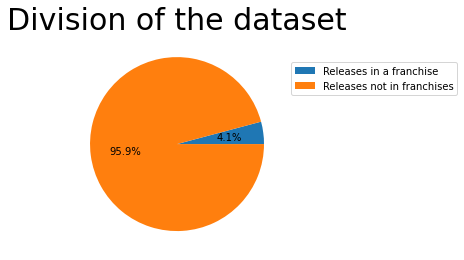

In [216]:
pie = plt.pie([complete_df[~complete_df["franchise_id"].isna()].tconst.nunique(), complete_df[complete_df["franchise_id"].isna()].tconst.nunique()], autopct='%1.1f%%')
plt.legend(pie[0], ["Releases in a franchise", "Releases not in franchises"], bbox_to_anchor=(1,0.9))
plt.title("Division of the dataset", fontsize = plot_title_size)

plt.show()

And this can be broken down further into movies and games:

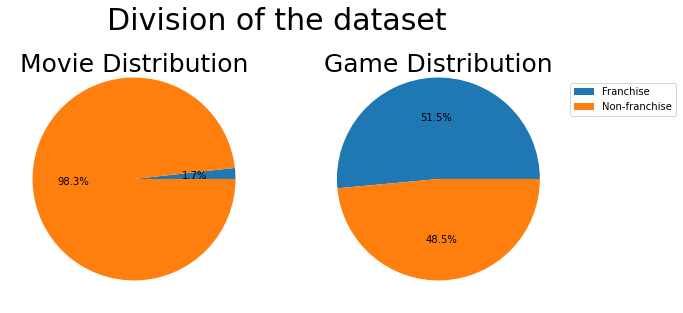

In [217]:
import matplotlib.pyplot as plt

movie_franchise_count = complete_df[(complete_df["type"] == "movie") & (~complete_df["franchise_id"].isna())]["tconst"].nunique()
movie_non_franchise_count = complete_df[(complete_df["type"] == "movie") & (complete_df["franchise_id"].isna())]["tconst"].nunique()

game_franchise_count = complete_df[(complete_df["type"] == "game") & (~complete_df["franchise_id"].isna())]["tconst"].nunique()
game_non_franchise_count = complete_df[(complete_df["type"] == "game") & (complete_df["franchise_id"].isna())]["tconst"].nunique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie([movie_franchise_count, movie_non_franchise_count], autopct='%1.1f%%')
ax1.legend('', frameon=False)
ax1.set_title("Movie Distribution",  fontsize = subplot_title_size, y= 0.9)

ax2.pie([game_franchise_count, game_non_franchise_count], autopct='%1.1f%%')
ax2.legend(["Franchise", "Non-franchise"], bbox_to_anchor=(1, 0.9))
ax2.set_title("Game Distribution", fontsize = subplot_title_size, y=0.9)

plt.suptitle("Division of the dataset", fontsize = plot_title_size)
plt.show()


It's pretty clear that the bulk of our movies are not in a franchise whereas the games have closer to a 50/50 split between franchise vs non-franchise. For the purposes of the rest of our project, we will only be focusing on the franchised information, and will not be using the non-franchised information. However we'll save the dataframe to a csv so it's easy to do analysis comparing the two if needed.

In [218]:
dataset_dir = Path('final_dataframes')
dataset_dir.mkdir(exist_ok=True)

In [219]:
complete_df.to_csv("final_dataframes\\complete_dataset.csv")

In [233]:
#complete_df = pd.read_csv("final_dataframes\\complete_dataset.csv", index_col = 0)

## Organising the franchises

Now we will begin to add additional information that will help with further analysis. We won't be using the non-franchised information from this point on. The first thing we will do is to calculate the first and last year in each franchise and where in the franchise each entry sits.

In [221]:
complete_df.dropna(subset=["franchise_id"], inplace=True)

In [222]:
complete_df.head(20)

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases
0,The Aldrich Family,f0,tt0032123,What a Life,1939,0.0,75,"['Comedy', 'Drama']",6.9,93.0,movie,NaN,NaN,NaN,NaN,11.0
1,The Aldrich Family,f0,tt0033834,Life with Henry,1940,0.0,80,"['Comedy', 'Family', 'Music']",6.0,49.0,movie,NaN,NaN,NaN,NaN,11.0
2,The Aldrich Family,f0,tt0033708,Henry Aldrich for President,1941,0.0,75,"['Comedy', 'Family']",6.6,146.0,movie,NaN,NaN,NaN,NaN,11.0
3,The Aldrich Family,f0,tt0034842,"Henry Aldrich, Editor",1942,0.0,72,"['Comedy', 'Drama', 'Family']",6.4,150.0,movie,NaN,NaN,NaN,NaN,11.0
4,The Aldrich Family,f0,tt0034844,Henry and Dizzy,1942,0.0,71,"['Comedy', 'Family']",7.2,58.0,movie,NaN,NaN,NaN,NaN,11.0
5,The Aldrich Family,f0,tt0035985,Henry Aldrich Swings It,1943,0.0,64,"['Comedy', 'Family']",8.3,110.0,movie,NaN,NaN,NaN,NaN,11.0
6,The Aldrich Family,f0,tt0035983,Henry Aldrich Gets Glamour,1943,0.0,72,"['Adventure', 'Comedy', 'Family']",6.4,130.0,movie,NaN,NaN,NaN,NaN,11.0
7,The Aldrich Family,f0,tt0035984,Henry Aldrich Haunts a House,1943,0.0,73,"['Adventure', 'Comedy', 'Family']",6.3,151.0,movie,NaN,NaN,NaN,NaN,11.0
8,The Aldrich Family,f0,tt0036909,"Henry Aldrich, Boy Scout",1944,0.0,66,"['Comedy', 'Family']",6.5,129.0,movie,NaN,NaN,NaN,NaN,11.0
9,The Aldrich Family,f0,tt0036907,Henry Aldrich Plays Cupid,1944,0.0,65,"['Comedy', 'Family']",8.2,100.0,movie,NaN,NaN,NaN,NaN,11.0


In [223]:
complete_df = complete_df.groupby('franchise_id').agg(first_year=('year', 'min'), last_year=('year', 'max'), \
                                                      lowest_vote=('votes', 'min'), highest_vote=('votes', 'max'), \
                                                      lowest_rating=('rating', 'min'), highest_rating=('rating', 'max')) \
       .reset_index() \
       .merge(complete_df, on='franchise_id', how='right') \
       .assign(franchise_pos=lambda x: (x['year'] - x['first_year']) / (x['last_year'] - x['first_year']) * 100)

We'll also calculate the lowest rated year and its position in the franchise

In [224]:
idx = complete_df.groupby('franchise_id')['rating'].idxmin()
complete_df = complete_df.sort_values(["franchise_id", "year"])

# Select the year value at the index and assign it to a new column for every row with the same franchise_id
complete_df['lowest_rated_year'] = complete_df.loc[idx, 'year'].values.repeat(complete_df.groupby('franchise_id').size())
complete_df['lowest_rated_pos'] = complete_df.loc[idx, 'franchise_pos'].values.repeat(complete_df.groupby('franchise_id').size())

Now we'll calculate the average rating before and after the lowest rated year.

In [225]:
complete_df["pos_rel_to_lowest_year"] = complete_df.apply(lambda x: 'pre' if x['year'] < x['lowest_rated_year'] else ('post' if x['year'] > x['lowest_rated_year'] else 'lowest'), axis=1)
complete_df['avg_rating_pre_lowest_year'] = complete_df.groupby('franchise_id')['rating'].transform(lambda x: x.loc[complete_df['pos_rel_to_lowest_year'] == 'pre'].mean())
complete_df['avg_rating_post_lowest_year'] = complete_df.groupby('franchise_id')['rating'].transform(lambda x: x.loc[complete_df['pos_rel_to_lowest_year'] == 'post'].mean())

In [226]:
complete_df.sample()

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year
13658,3025-1493,2002,2019,55.0,131.0,7.2,8.2,Shantae,tt5685938,Shantae: Half-Genie Hero,2016,0.0,NaN,"['Animation', ' Platformer', ' Action', ' Adve...",7.3,131.0,game,"['WayForward Technologies', 'Inti Creates Co.,...","['PC', 'PlayStation Vita', 'Wii U', 'PlayStati...","['WayForward Technologies', 'XSEED Games']",['ESRB: T'],5.0,82.352941,2002,0.0,post,NaN,7.6


We can create a rolling mean for our data to get average rating over time, as well as getting the current number in the franchise over time.

In [227]:
complete_df['rolling_avg_rating'] = complete_df.groupby('franchise_id')['rating'].expanding().mean().reset_index(0, drop=True)
complete_df['current_num_in_fran'] = complete_df.groupby('franchise_id')['year'].rank(method='first', ascending=True)

In [228]:
complete_df

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran
6057,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0315808,Baseball,1978,0.0,NaN,"['Baseball', ' Sports', ' Family', ' Sport']",3.0,14.0,game,['Nintendo R&D1'],"['Game Boy', 'Game Boy Advance', 'Nintendo Ent...","['Nintendo', 'HAMSTER Corporation']",['ESRB: E'],197.0,0.000000,1994,36.363636,pre,6.357143,7.007042,3.000000,1.0
6059,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0355727,Major League Baseball,1980,0.0,NaN,"['Baseball', ' Sports', ' Family', ' Sport']",4.9,15.0,game,['Nintendo R&D1'],"['Game Boy', 'Game Boy Advance', 'Nintendo Ent...","['Nintendo', 'HAMSTER Corporation']",['ESRB: E'],197.0,4.545455,1994,36.363636,pre,6.357143,7.007042,3.950000,2.0
6011,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0176664,Donkey Kong,1981,0.0,NaN,"['Platformer', ' Action', ' Puzzle']",7.4,2039.0,game,['Nintendo EAD'],"['Game Boy', 'Nintendo 3DS eShop']",['Nintendo'],"['ESRB: E', 'CERO: A', 'PEGI: 3+']",197.0,6.818182,1994,36.363636,pre,6.357143,7.007042,5.100000,3.0
6018,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0204287,Donkey Kong Junior,1982,0.0,NaN,"['Action', ' Family']",6.6,313.0,game,['Nintendo'],['DSiWare'],['Nintendo'],"['ESRB: E', 'OFLC: G']",197.0,9.090909,1994,36.363636,pre,6.357143,7.007042,5.475000,4.0
6174,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt3472820,Donkey Kong,1982,0.0,NaN,"['Platformer', ' Action', ' Family', ' Puzzle']",6.3,36.0,game,['Nintendo EAD'],"['Game Boy', 'Nintendo 3DS eShop']",['Nintendo'],"['ESRB: E', 'CERO: A', 'PEGI: 3+']",197.0,9.090909,1994,36.363636,pre,6.357143,7.007042,5.640000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,f994,1948,1950,99.0,658.0,6.0,7.0,Renato Castellani's Italian neorealism trilogy,tt0042060,You're My Everything,1950,0.0,94,"['Comedy', 'Musical']",6.0,180.0,movie,NaN,NaN,NaN,NaN,4.0,100.000000,1950,100.000000,lowest,6.900000,NaN,6.575000,4.0
3286,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0071198,The Bat People,1974,0.0,93,"['Horror', 'Romance']",2.7,2598.0,movie,NaN,NaN,NaN,NaN,4.0,0.000000,1974,0.000000,lowest,NaN,5.000000,2.700000,1.0
3287,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0071675,It's Alive,1974,0.0,91,"['Horror', 'Sci-Fi']",5.8,8301.0,movie,NaN,NaN,NaN,NaN,4.0,0.000000,1974,0.000000,lowest,NaN,5.000000,4.250000,2.0
3288,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0077756,It Lives Again,1978,0.0,91,"['Horror', 'Sci-Fi']",5.2,2494.0,movie,NaN,NaN,NaN,NaN,4.0,30.769231,1974,0.000000,post,NaN,5.000000,4.566667,3.0


## Splitting the data
At this stage we are going to create 3 separate dataframes. The first will be the one we currently have. This is where every item in each franchise has it's own row. The second dataframe will group all the franchises by year, and each unique year for each franchise will be a single entry. The final dataframe will group all the entries for each franchises into a single row to give an overview of the franchise as a whole.

### Dataframe 1:

This is already complete. We will save to a csv file for easy access later.

In [245]:
complete_df.to_csv("final_dataframes\\df_individual_entries.csv")

### Dataframe 2:

In this dataframe, we want to group all the franchises by year, to allow us to tackle the data in a different way:

In [230]:
merged_years_df = complete_df.copy(deep=True)

Get total for each year, for each franchise

In [231]:
merged_years_df['content_per_year'] = merged_years_df.groupby(["franchise_id", "year"])["year"].transform('count')

Create average votes and ratings for each franchise

In [232]:
grouped_movies = merged_years_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_years_df = pd.merge(merged_years_df, grouped_movies, on=["franchise_id", "year"], how="left", suffixes=(None, '_average'))

In [234]:
merged_years_df.sample()

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran,content_per_year,votes_average,rating_average
7157,3025-520,1999,2020,17.0,2614.0,6.5,8.4,Medal of Honor,tt1085850,Medal of Honor: Airborne,2007,0.0,NaN,"['First-Person Shooter', ' War', ' Action', ' ...",7.3,1454.0,game,"['Demiurge Studios', 'EA Los Angeles', 'Papaya...","['Xbox 360', 'PlayStation 3', 'PC']",['Electronic Arts'],"['ESRB: T', 'PEGI: 16+']",17.0,38.095238,2006,33.333333,post,7.77,7.15,7.592308,13.0,3,579.666667,7.2


In [239]:
# group by name and release year, aggregate the franchise_id lists
merged_years_df = merged_years_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    "type": "first",
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "votes_average": "first", 
    "rating_average": "first", 
    "number_of_releases" : "first",
    "content_per_year": "first", 
    "first_year": "first",
    "last_year": "first",
    "lowest_vote": "first",
    "highest_vote" : "first",
    "lowest_rating" : "first",
    "highest_rating" : "first",
    "franchise_pos": "last",
    "lowest_rated_year" : "first",
    "lowest_rated_pos" : "first",
    "pos_rel_to_lowest_year": "first",
    "avg_rating_pre_lowest_year": "first",
    "avg_rating_post_lowest_year": "first",
    "rolling_avg_rating": "last",
    "current_num_in_fran": "last"    
    
# Note that we are dropping these for simplicities sake: is_adult, runtime, genres, developers, platforms, publishers, age_rating
}))

Create columns that have the difference in year between the previous entries in the franchise, the difference in average vote count and avaerage rating

In [241]:
merged_years_df.head(10)

,franchise_name,franchise_id,type,tconst,title,year,votes_average,rating_average,number_of_releases,content_per_year,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_pos,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran
0,Mario,3025-1,game,tt0315808,Baseball,1978,14.000000,3.000000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,0.000000,1994,36.363636,pre,6.357143,7.007042,3.000000,1.0
1,Mario,3025-1,game,tt0355727,Major League Baseball,1980,15.000000,4.900000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,4.545455,1994,36.363636,pre,6.357143,7.007042,3.950000,2.0
2,Mario,3025-1,game,tt0176664,Donkey Kong,1981,2039.000000,7.400000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,6.818182,1994,36.363636,pre,6.357143,7.007042,5.100000,3.0
3,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,174.500000,6.450000,197.0,2,1978,2022,6.0,6633.0,1.9,9.2,9.090909,1994,36.363636,pre,6.357143,7.007042,5.640000,5.0
4,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,328.400000,6.020000,197.0,5,1978,2022,6.0,6633.0,1.9,9.2,11.363636,1994,36.363636,pre,6.357143,7.007042,5.830000,10.0
5,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,50.000000,5.850000,197.0,4,1978,2022,6.0,6633.0,1.9,9.2,13.636364,1994,36.363636,pre,6.357143,7.007042,5.835714,14.0
6,Mario,3025-1,game,tt0177266,Super Mario Bros.,1985,6633.000000,8.900000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,15.909091,1994,36.363636,pre,6.357143,7.007042,6.040000,15.0
7,Mario,3025-1,game,"tt0204658, tt0302502, tt3417312, tt3422316, tt...","Super Mario Bros.: The Lost Levels, Donkey Kon...",1986,236.142857,6.600000,197.0,7,1978,2022,6.0,6633.0,1.9,9.2,18.181818,1994,36.363636,pre,6.357143,7.007042,6.218182,22.0
8,Mario,3025-1,game,"tt0204284, tt3425360","Yume Koujou: Doki Doki Panic, Famicom Grand Pr...",1987,24.000000,6.450000,197.0,2,1978,2022,6.0,6633.0,1.9,9.2,20.454545,1994,36.363636,pre,6.357143,7.007042,6.237500,24.0
9,Mario,3025-1,game,"tt0204659, tt0249174, tt0302503, tt0311026, tt...","Super Mario Bros. 2, Super Mario Bros. 3, Donk...",1988,1478.833333,6.533333,197.0,6,1978,2022,6.0,6633.0,1.9,9.2,22.727273,1994,36.363636,pre,6.357143,7.007042,6.296667,30.0


We'll now get the difference between the years, ratings, votes and number of releases

In [243]:
merged_years_df = merged_years_df.sort_values(["franchise_id", "year"])
merged_years_df['year_diff'] = merged_years_df.groupby(['franchise_id'])['year'].diff()
merged_years_df['vote_diff'] = merged_years_df.groupby(['franchise_id'])['votes_average'].diff()
merged_years_df['rating_diff'] = merged_years_df.groupby(['franchise_id'])['rating_average'].diff()
merged_years_df['num_of_releases_diff'] = merged_years_df.groupby(['franchise_id'])['content_per_year'].diff()

In [244]:
merged_years_df

,franchise_name,franchise_id,type,tconst,title,year,votes_average,rating_average,number_of_releases,content_per_year,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_pos,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran,year_diff,vote_diff,rating_diff,num_of_releases_diff
0,Mario,3025-1,game,tt0315808,Baseball,1978,14.000000,3.000000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,0.000000,1994,36.363636,pre,6.357143,7.007042,3.000000,1.0,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0355727,Major League Baseball,1980,15.000000,4.900000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,4.545455,1994,36.363636,pre,6.357143,7.007042,3.950000,2.0,2.0,1.000000,1.900000,0.0
2,Mario,3025-1,game,tt0176664,Donkey Kong,1981,2039.000000,7.400000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,6.818182,1994,36.363636,pre,6.357143,7.007042,5.100000,3.0,1.0,2024.000000,2.500000,0.0
3,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,174.500000,6.450000,197.0,2,1978,2022,6.0,6633.0,1.9,9.2,9.090909,1994,36.363636,pre,6.357143,7.007042,5.640000,5.0,1.0,-1864.500000,-0.950000,1.0
4,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,328.400000,6.020000,197.0,5,1978,2022,6.0,6633.0,1.9,9.2,11.363636,1994,36.363636,pre,6.357143,7.007042,5.830000,10.0,1.0,153.900000,-0.430000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0038970,Sotto il sole di Roma,1948,311.000000,6.900000,4.0,1,1948,1950,99.0,658.0,6.0,7.0,0.000000,1950,100.000000,pre,6.900000,NaN,6.900000,1.0,NaN,NaN,NaN,NaN
10976,Renato Castellani's Italian neorealism trilogy,f994,movie,"tt0040018, tt0044572, tt0042060","It's Forever Springtime, Two Cents Worth of Ho...",1950,312.333333,6.466667,4.0,3,1948,1950,99.0,658.0,6.0,7.0,100.000000,1950,100.000000,lowest,6.900000,NaN,6.575000,4.0,2.0,1.333333,-0.433333,2.0
10977,It's Alive,f995,movie,"tt0071198, tt0071675","The Bat People, It's Alive",1974,5449.500000,4.250000,4.0,2,1974,1987,2068.0,8301.0,2.7,5.8,0.000000,1974,0.000000,lowest,NaN,5.000000,4.250000,2.0,NaN,NaN,NaN,NaN
10978,It's Alive,f995,movie,tt0077756,It Lives Again,1978,2494.000000,5.200000,4.0,1,1974,1987,2068.0,8301.0,2.7,5.8,30.769231,1974,0.000000,post,NaN,5.000000,4.566667,3.0,4.0,-2955.500000,0.950000,-1.0


Finally, we can save the results to a csv.

In [246]:
merged_years_df.to_csv("final_dataframes\\df_merged_years.csv")

### Dataframe 3:

In this dataframe, we want to group all the franchises into a single entry per franchise.

## *Note*
Using value_counts we discover 25% of our movies for the franchises are released in the same year. So we have to either get an average per year (in this case, we are looking at fatique over years as opposed to number of movies)

# Normalize and z-scores

In [147]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])

In [148]:
cols = ["tconst", "rating_average", "votes_average", "year"]

games_scores = merged_years_df[merged_years_df["type"] == "game"][cols]

movies_scores = merged_years_df[merged_years_df["type"] == "movie"][cols]

In [149]:
%matplotlib inline

sns.set_context("talk", font_scale=.9)   
sns.set_context('talk')

fig_width, fig_height = 4, 3

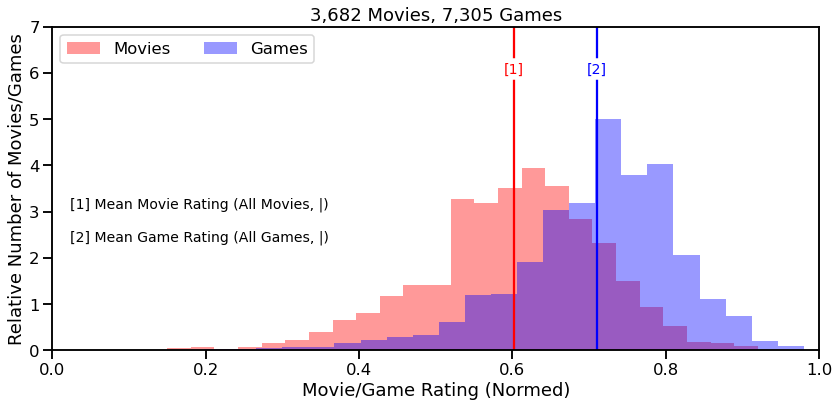

In [150]:
fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))

interval = 0.01
((movies_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_ylim(0, 7)
ax.set_xlim(0, 1)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

mean_movie_rating = (movies_scores['rating_average']/10).mean()
mean_game_rating = (games_scores['rating_average']/10).mean()

ax.axvline(mean_movie_rating, color="red")
ax.axvline(mean_game_rating, color="blue")

ax.text(mean_movie_rating, 6, '[1]', ha='center',color="red", backgroundcolor='w', fontsize=14)

ax.text(mean_game_rating, 6, '[2]', ha='center',color="blue", backgroundcolor='w', fontsize=14)


ax.text(
    0, 2,
    '''
    [1] Mean Movie Rating (All Movies, |)
    
    [2] Mean Game Rating (All Games, |)
    ''',
    fontsize=14
)

ax.set_xlabel('Movie/Game Rating (Normed)')
ax.set_ylabel('Relative Number of Movies/Games')

ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_scores), len(games_scores)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_1_normed_rating_distributions.png', format='png', dpi=300)

In [151]:
merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].agg(['mean', 'std'])

mean    6.019407
std     1.143356
Name: rating_average, dtype: float64

In [152]:
(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']-merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].mean())/complete_df[complete_df["type"] == "movie"]['rating'].std()

7305     0.646067
7306    -0.014239
7307     0.425965
7308     0.572700
7309     0.719435
           ...   
10982    0.279231
10983    0.719435
10984   -1.298167
10985   -0.601177
10986   -0.894647
Name: rating_average, Length: 3682, dtype: float64

In [153]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])

7305     0.770287
7306    -0.016976
7307     0.507866
7308     0.682813
7309     0.857760
           ...   
10982    0.332918
10983    0.857760
10984   -1.547765
10985   -0.716766
10986   -1.066660
Name: rating_average, Length: 3682, dtype: float64

In [154]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']).mean()

6.061299087728109e-16

In [155]:
merged_years_df["z_rating"] = np.nan

In [156]:
merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])
merged_years_df.sort_values("z_rating")

C:\Users\35387\AppData\Local\Temp\ipykernel_109712\1374468612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])


,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating
0,Mario,3025-1,game,tt0315808,Baseball,1978,0,None,"[ Family, Sports, Sport, Baseball]",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0176664,Donkey Kong,1981,0,None,"[ Platformer, Action]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0,NaN
2,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,None,"[ Platformer, Action, Family]",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0,NaN
3,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,None,"[ Pinball, Fantasy, Sports, Baseball, \\N, ...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0,NaN
4,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,None,"[Golf, Sports, Sport, Puzzle, Action, Plat...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10982,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0040018,it's forever springtime,1950,0,92,"[Drama, Comedy]",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0,NaN
10983,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0044572,two cents worth of hope,1952,0,110,"[Romance, Comedy]",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0,NaN
10984,It's Alive,f995,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Horror, Sci-Fi, Romance]",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,NaN
10985,It's Alive,f995,movie,tt0077756,it lives again,1978,0,91,"[Horror, Sci-Fi]",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0,NaN


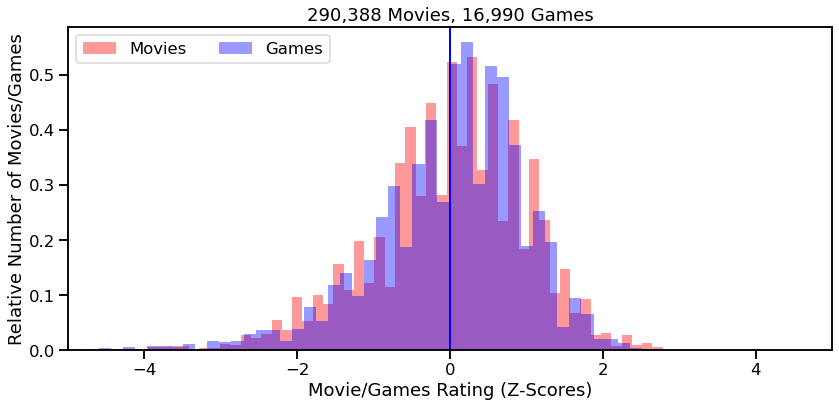

In [157]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])

merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])

fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))


((merged_years_df[merged_years_df["type"] == "movie"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="red", density=True, alpha=.4)
((merged_years_df[merged_years_df["type"] == "game"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_xlim(-5, 5)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

ax.axvline((merged_years_df[merged_years_df["type"] == "movie"]['z_rating']).mean(), lw=2, c="red")
ax.axvline((merged_years_df[merged_years_df["type"] == "game"]['z_rating']).mean(), lw=2, c="blue")


ax.set_xlabel('Movie/Games Rating (Z-Scores)')
ax.set_ylabel('Relative Number of Movies/Games')
ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_df), len(games_df)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_2_z_rating_distributions.png', format='png', dpi=300)

In [158]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'votes_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'votes_average'])

In [159]:
complete_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count,year_type
254059,NaN,NaN,tt5155486,filth city,2017,0,99,"Action,Comedy,Crime",4.4,807.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [160]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes
10285,Saw,f689,movie,tt1477076,saw 3d,2010,0,90,"[Crime, Mystery, Horror]",101449.0,5.5,10.0,1.0,1.0,-14078.0,-0.5,0.0,-0.454345,0.18993


In [161]:
test = merged_years_df[(merged_years_df["type"] == "movie") & (merged_years_df["votes_average"] > 100)]
test["votes_average"].describe()

count    3.196000e+03
mean     7.533188e+04
std      2.019385e+05
min      1.007500e+02
25%      6.220000e+02
50%      3.569000e+03
75%      3.523400e+04
max      2.700528e+06
Name: votes_average, dtype: float64

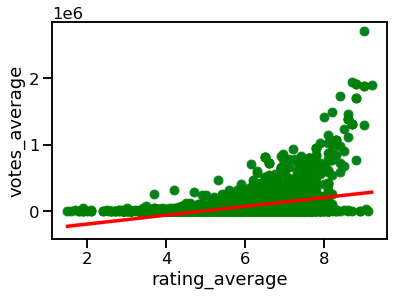

In [162]:
x = test["rating_average"]
y = test["votes_average"]

sns.scatterplot(x =x, y = y)
sns.regplot(x=x, y = y, scatter_kws = dict(color = "green"), line_kws = {"color": "red"})
#plt.yscale("log")
plt.show()

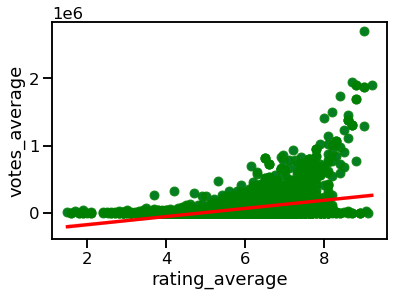

In [163]:
x = merged_years_df[merged_years_df["type"] == "movie"]["rating_average"]
y = merged_years_df[merged_years_df["type"] == "movie"]["votes_average"]

sns.scatterplot(x =x, y = y)
sns.regplot(x=x, y = y, scatter_kws = dict(color = "green"), line_kws = {"color": "red"})
plt.show()

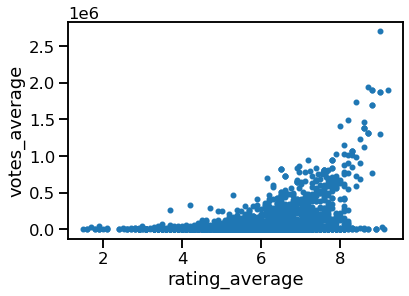

In [164]:
ax = merged_years_df[merged_years_df["type"] == "movie"].plot.scatter(x = "rating_average", y = "votes_average")
#ax.set_xlim(-6, 6)
#ax.set_ylim(-6, 6)

In [165]:
merged_years_df.to_csv("franchises_combined_by_year.csv")

## Interesting information

In [105]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes
9592,Philo Vance,f52,movie,"tt0027656, tt0144592","the garden murder case, the scarab murder case",1936,0,61,"[Crime, Adventure, Drama, Mystery]",279.0,5.6,15.0,2.0,1.0,-438.0,-0.5,1.0,-0.366871,-0.343024


In [106]:
merged_years_df["number_of_releases"].describe()

count    10987.000000
mean        15.322199
std         24.733459
min          3.000000
25%          4.000000
50%          7.000000
75%         16.000000
max        216.000000
Name: franchise_count, dtype: float64

In [115]:
merged_years_df[merged_years_df["type"] == "movie"]["number_of_releases"].value_counts()

3.0     1152
4.0      524
5.0      316
6.0      247
7.0      217
10.0     107
8.0      106
12.0      98
9.0       95
13.0      83
19.0      70
11.0      66
15.0      51
21.0      45
16.0      41
25.0      40
28.0      39
18.0      35
36.0      34
14.0      33
24.0      33
33.0      32
31.0      28
22.0      27
20.0      25
46.0      20
30.0      16
32.0      14
66.0      14
48.0      13
23.0      12
47.0       9
51.0       9
63.0       9
42.0       7
39.0       7
27.0       5
17.0       3
Name: franchise_count, dtype: int64

In [167]:
merged_years_df[merged_years_df["type"] == "game"]["number_of_releases"].median()

9.0

## Additional Unused Code

In [ ]:
def sample_func(sub_df):
    
    movies_in_order = sub_df.sort_values('year')['tconst']
    return pd.Series({movie: k+1 for k, movie in enumerate(movies_in_order)})

In [ ]:
sample_df = movies_df.sample(10000)
grouped_df = sample_df.groupby('franchise_id').apply(sample_func)

In [ ]:
franchise_df = grouped_df[grouped_df['franchise_id'] == 'f1334']

In [ ]:
sample_func(franchise_df)

In [ ]:
l = ['a','b','c']
for k,i in enumerate(l):
    print(k,i)
    print(i,  '-->',  k+1)

In [ ]:
franchise_df.sort_values('startYear')['startYear']

In [ ]:
franchise_df.set_index('tconst').sort_values('startYear')['startYear'].map(int).diff()